In [127]:
# Run with 'solar': conda
%reset -f
from tsai.all import *

Create `numpy` array with four columns.

In [128]:
data1 = np.concatenate([np.ones((20,1), dtype=int), np.arange(20).reshape(-1,1).repeat(3,1) * np.array([1,2,3])], 1)
data2 = np.concatenate([np.ones((15,1), dtype=int)*2, np.arange(15).reshape(-1,1).repeat(3,1) * np.array([1,2,3]) + .5], 1)
data = np.concatenate([data1, data2])
df = pd.DataFrame(data, columns=['unique_id', 'var1', 'var2', 'target'])

Create `dataframe` with four columns.

In [129]:
df = pd.DataFrame(data, columns=['unique_id', 'var1', 'var2', 'target'])

(35, 5)


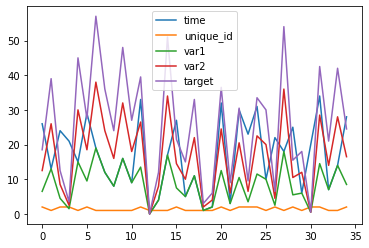

In [130]:
np.random.seed(42)
df = df.loc[np.random.choice(len(df), len(df), False)].reset_index()
df.rename(columns={'index': 'time'}, inplace=True)
df.plot();
print(df.shape)

`SlidingWindow` parameters.

In [131]:
window_len = 5 # Length of lookback.
unique_id_cols = ['unique_id'] # pd.DataFrame columns that will be used to identify a time series for each entity.
stride = 1 # Number of datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap).
start = 0 # Determines the step where the first window is applied. Default: 0. Previous steps will be discarded. 
pad_remainder = False # Allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
padding = 'pre' 'pre' or 'post' # (Optional) Pad either before or after each sequence. Defaults: 'pre'. If pad_remainder == False, it indicates the starting point to create the sequence ('pre' from the end, and 'post' from the beginning)
padding_value = np.nan # Float that will be used for padding. Default: np.nan.
add_padding_feature = True # Add an additional feature indicating whether each timestep is padded (1) or not (0).
get_x = ['var1', 'var2', 'target'] # Indices of columns that contain the independent variable (xs). If None, all data will be used as x.
get_y = 'target' # Indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
y_func = None # Optional function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!.
horizon = 4 # Number of future datapoints to predict (y). If get_y is [] horizon will be set to 0.
output_processor = [] # (Optional) Function to process the final output (X (and y if available)). This is useful when some values need to be removed.
seq_first = True # True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len).
sort_by = ['time'] # Column/s used for sorting the array in ascending order.
ascending = True # Used in sorting.
check_leakage = True # Checks if there's leakage in the output between X and y
return_key = False # When True, the key corresponsing to unique_id_cols for each sample is returned
verbose = True # Controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.
copy_=True # Copy the original object to avoid changes in it.

Apply `SlidingWindowPanel` on `DataFrame`.

In [132]:
X, y = SlidingWindowPanel(window_len=window_len,
                          unique_id_cols=unique_id_cols,
                          stride=stride,
                          start=start,
                          padding=padding,
                          pad_remainder=pad_remainder,
                          padding_value=padding_value,
                          add_padding_feature=add_padding_feature,
                          get_x=get_x,
                          get_y=get_y,
                          #output_processor=output_processor,
                          y_func=y_func,
                          horizon=horizon,
                          seq_first=seq_first,
                          sort_by=sort_by,
                          ascending=ascending,
                          check_leakage=check_leakage,
                          return_key=return_key,
                          #copy=copy_,
                          verbose=verbose)(df)

UnboundLocalError: local variable 'X_start' referenced before assignment

Faster way to apply `SlidingWindow` (on `ndarray`, `Tensor` or `DataFrame`)

In [ ]:
output = [df.groupby(['unique_id']).apply(lambda x: SlidingWindow(window_len=window_len,
                                                                  stride=stride,
                                                                  start=start,
                                                                  pad_remainder=pad_remainder,
                                                                  padding_value=padding_value,
                                                                  add_padding_feature=add_padding_feature,
                                                                  get_x=get_x,
                                                                  get_y=get_y,
                                                                  y_func=y_func,
                                                                  horizon=horizon,
                                                                  seq_first=seq_first,
                                                                  sort_by=sort_by,
                                                                  ascending=ascending,
                                                                  check_leakage=check_leakage,
                                                                  copy=copy_, # it's important to set copy to True when used in this way!!!
                                                                  )(x))][0].values

X2 = np.concatenate([oi[0] for oi in output])
y2 = np.concatenate([oi[1] for oi in output])

(Samples, Features, Timesteps)

In [ ]:
print(X.shape, y.shape)
print(X2.shape, y2.shape)

(9, 3, 10) (9, 4)
(9, 3, 10) (9, 4)


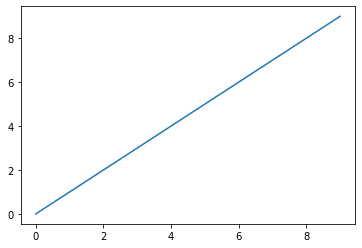

In [ ]:
plt.plot(X[0,0,:])